**2. Two-Way ANOVA** - Two Factorial
> Two-way ANOVA is an extension of the one-way ANOVA that examines the influence of two different categorical independent variables (factors) on one continuous dependent variable. It helps in examining the effect of these two factors on the dependent variable, as well as any interaction between the factors.
> 
> |  |  |  |
> |--|--|--|
> | $H_0$ | $μ_1 = μ_2 =... = μ_n$    | → There are no difference between means of the groups based on Factor A. <br> → There are no difference between means of the groups based on Factor B. <br> → There are no difference between means of the groups based on interction between Factor A and B. |
> | $H_1$ | $∃i,j \ \ such\ that \ \ i ≠ j\ and\ μ_i ≠ μ_j$ | → At least one group with a different mean for Factor A. <br>→ At least one group with a different mean for Factor B. <br> → At least one group with a different mean for interaction between Factor A and B. |
> 
> **ASSUMTIONS**
> 
>  → Data within the groups should be normally distributed. (Residuals should be normally distributed.)<br>
>  → The Variance of data in groups should be equal. <br>
> > If homogeneity assumption is not met, we should use **Welch's ANOVA** which is an alternative to the classic ANOVA and can be used even if your data violates the assumption of homogeneity of variances.
> 
> → The measurements should be independent. <br>
> → The dependent variable should have a metric scale level.

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [1]:
import pandas as pd
import pingouin as pg
from scipy import stats
import statsmodels.stats as ss

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt

α = alpha = 0.05

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; TWO-WAY ANOVA </p>

**Subject :** Comparison of quality of crops based on the types of fertilizers and seeds used <br>
**Data :** 6_crop_quality.csv

|  |  |
|--|--|
| $H_0$ | → Fertilizer type has no significant effect on the mean quality (There is no difference in the mean quality between different fertilizer types). <br> → Seed type has no significant effect on the mean quality (There is no difference in the mean quality between different seed types). <br> → There is no interaction effect between fertilizer type and seed type on the mean quality.|
| $H_1$ | → Fertilizer type has a significant effect on the mean quality . <br> → Seed type has a significant effect on the mean quality  <br> → There is a significant interaction effect between fertilizer type and seed type on the mean quality.|

In [2]:
data = pd.read_csv('data/06_crop_quality.csv')
display(data.sample(3))

,Fertilizer,Seed,Quality
29,Multinutrient,Jalapeño Peppers:,4.03
24,Balanced,Bell Peppers:,4.36
14,Balanced,Cayenne Peppers,2.87


In [3]:
display(data.describe(include=['category', 'object']))

,Fertilizer,Seed
count,30,30
unique,3,4
top,Balanced,Bell Peppers:
freq,12,8


**1. Data Preparation**

In [4]:
data['Interaction'] = data['Fertilizer'] + ' & ' + data['Seed']

groups_f = data.groupby('Fertilizer')['Quality']
groups_s = data.groupby('Seed')['Quality']
groups_i = data.groupby('Interaction')['Quality']

**2. Normality Test**

In [5]:
normality_f = pg.normality(data, dv='Quality', group='Fertilizer', method='shapiro', alpha=alpha)
normality_s = pg.normality(data, dv='Quality', group='Seed', method='shapiro', alpha=alpha)
# normality_i = pg.normality(data, dv='Quality', group='Interaction', method='shapiro', alpha=alpha)

display(normality_f, normality_s) # normality_i

,W,pval,normal
Fertilizer,,,
Balanced,0.933093,0.414049,True
Multinutrient,0.725036,0.001773,False
NPK,0.991620,0.997191,True


,W,pval,normal
Seed,,,
Bell Peppers:,0.902464,0.304026,True
Jalapeño Peppers:,0.966830,0.872034,True
Cayenne Peppers,0.966881,0.875122,True
Habanero Peppers,0.964537,0.856582,True


Except for group **Multinutrient**, the null hypotheses cannot be rejected, groups are normally distribution.

&emsp;*In many applications with a moderate or larger sample size, a two-way ANOVA may yield reasonably accurate p values even when the normality assumption is violated. In some applications with nonnormal populations, a sample size of 15 cases per group might be sufficiently large to yield fairly accurate p values. **(Green and Salkind, 2014)***

**3. Homogeneity Test**

In [6]:
homogeneity_f = pg.homoscedasticity(data, dv='Quality', group='Fertilizer', method='bartlett')
homogeneity_s = pg.homoscedasticity(data, dv='Quality', group='Seed', method='bartlett')
homogeneity_i = pg.homoscedasticity(data, dv='Quality', group='Interaction', method='bartlett')

homogeneity = pd.concat([homogeneity_f, homogeneity_s, homogeneity_i])
homogeneity['Factor'] = ['Fertilizer', 'Seed', 'Interaction']
display(homogeneity)

,T,pval,equal_var,Factor
bartlett,0.158249,0.923925,True,Fertilizer
bartlett,0.958887,0.811199,True,Seed
bartlett,11.501602,0.402246,True,Interaction


**4. Test Implementation** - Two-Way ANOVA

In [7]:
formula = 'Quality ~ C(Fertilizer) + C(Seed) + C(Fertilizer) : C(Seed)'
# formula = 'Quality ~ C(Fertilizer) + C(Seed) + C(Interaction)'  # DO NOT

model = ols(formula, data=data).fit()
anova = sm.stats.anova_lm(model, typ=2)
# if the number of group observations is equal typ=2, if not typ=3

anova['Decision'] = anova['PR(>F)'].map(lambda x: True if x>alpha else False)
display(anova)

,sum_sq,df,F,PR(>F),Decision
C(Fertilizer),1.764202,2.0,0.533454,0.595567,True
C(Seed),1.680502,3.0,0.338763,0.797537,True
C(Fertilizer):C(Seed),4.429142,6.0,0.446423,0.838069,True
Residual,29.764200,18.0,NaN,NaN,False


In [8]:
test = pg.anova(data=data, dv='Quality', between=['Fertilizer',  'Seed'])
test['Decision'] = test['p-unc'].map(lambda x: True if x>alpha else False)
display(test)

,Source,SS,DF,MS,F,p-unc,np2,Decision
0,Fertilizer,1.764202,2.0,0.882101,0.533454,0.595567,0.055956,True
1,Seed,1.680502,3.0,0.560167,0.338763,0.797537,0.053443,True
2,Fertilizer * Seed,4.429142,6.0,0.738190,0.446423,0.838069,0.129532,True
3,Residual,29.764200,18.0,1.653567,NaN,NaN,NaN,False


<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

**Subject :** Comparison of employee performance based on position and collaboration period <br>
**Data :** 7_employee performance.csv

|  |  |
|--|--|
| $H_0$ | → There is no significant difference in the average performance of employees across different positions. <br> → There is no significant difference in the average performance of employees across different collaboration periods. <br> → There is no significant interaction effect between position and collaboration period on the average performance of employees.|
| $H_1$ | → At least one position group differs significantly from the others in terms of average performance. <br> → At least one group in the collaboration period differs significantly from the others in terms of average performance. <br> → There is a significant interaction effect between position and collaboration period on the average performance of employees.|

In [9]:
data = pd.read_csv('data/07_employee performance.csv')

formula = 'Performance ~ C(Position) + C(Duration) + C(Position) : C(Duration)'
model = ols(formula, data).fit()

,W,pval,normal
0,0.980799,0.612279,True


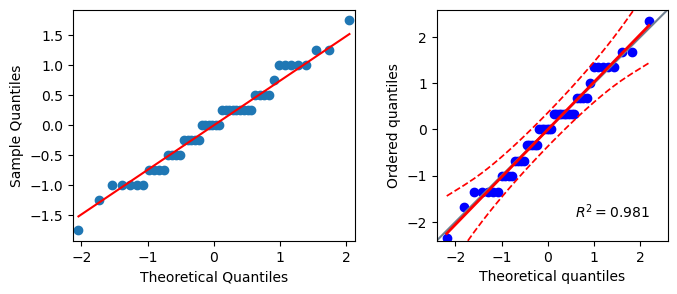

In [10]:
resids = model.resid
normality = pg.normality(resids, method='shapiro', alpha=alpha)
display(normality)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
sm.qqplot(resids, line='s', ax=ax1)
pg.qqplot(resids, dist='norm', ax=ax2)
plt.show()

In [11]:
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Performance   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     30.06
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           7.41e-15
Time:                        14:36:24   Log-Likelihood:                -53.852
No. Observations:                  48   AIC:                             131.7
Df Residuals:                      36   BIC:                             154.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    6.5000      0.429     15.152      0.000       5.630       7.370
C(Position)[T.Manager]                                       1.5000      0.607      2.472      0.018       0.270       2.730
C(Position)[T.Worker]                                       -2.0000      0.607     -3.297      0.002      -3.230      -0.770
C(Duration)[T.One Month]                                     0.2500      0.607      0.412      0.683      -0.980       1.480
C(Duration)[T.One Year]                                     -0.5000      0.607     -0.824      0.415      -1.730       0.730
C(Duration)[T.Three Year or More]                           -0.5000      0.607     -0.824      0.415      -1.730       0.730
C(Position)[T.Manager]:C(Duration)[T.One Month]             -2.2500      0.858     -2.622      0.013      -3.990      -0.510
C(Position)[T.Worker]:C(Duration)[T.One Month]               0.5000      0.858      0.583      0.564      -1.240       2.240
C(Position)[T.Manager]:C(Duration)[T.One Year]               1.7500      0.858      2.040      0.049       0.010       3.490
C(Position)[T.Worker]:C(Duration)[T.One Year]               -1.2500      0.858     -1.457      0.154      -2.990       0.490
C(Position)[T.Manager]:C(Duration)[T.Three Year or More]     2.2500      0.858      2.622      0.013       0.510       3.990
C(Position)[T.Worker]:C(Duration)[T.Three Year or More]     -2.2500      0.858     -2.622      0.013      -3.990      -0.510
==============================================================================
Omnibus:                        0.108   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.947   Jarque-Bera (JB):                0.312
Skew:                           0.038   Prob(JB):                        0.855
Kurtosis:                       2.612   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**p value** (OLS Regression Results - Prob (F-statistic)) is less than 0.05, so $H_0$ cannot be rejected.

In [12]:
anova = sm.stats.anova_lm(model, typ=2)
anova['Decision'] = anova['PR(>F)'].map(lambda x: True if x>alpha else False)
display(anova)

,sum_sq,df,F,PR(>F),Decision
C(Position),177.541667,2.0,120.594340,1.105315e-16,False
C(Duration),1.583333,3.0,0.716981,5.483443e-01,True
C(Position):C(Duration),64.291667,6.0,14.556604,2.351726e-08,False
Residual,26.500000,36.0,NaN,NaN,False


| | |
|-|-|
| **Position** | At least one of the performance averages of the position groups is different. |
| **Duration** | There is no significant difference in the performance averages of the duration groups. |
| **Interaction** | At least one of the performance means of the Position & Duration groups is different. |

In [13]:
tukey_hsd = pg.pairwise_tukey(data=data, dv='Performance', between='Position')
tukey_hsd['Reject'] = tukey_hsd['p-tukey'].map(lambda p: False if p>alpha else True)
display(tukey_hsd[tukey_hsd['Reject']==True])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Reject
0,Foreman,Manager,6.3125,8.2500,-1.9375,0.506554,-3.824862,1.145131e-03,-1.428540,True
1,Foreman,Worker,6.3125,3.5625,2.7500,0.506554,5.428836,6.443621e-06,2.048464,True
2,Manager,Worker,8.2500,3.5625,4.6875,0.506554,9.253698,1.668266e-11,2.781878,True


In [14]:
# tukey_hsd = ss.multicomp.pairwise_tukeyhsd(endog=data['Performance'], 
#                                           groups=data['Position']+data['Duration'])
# print(tukey_hsd)

data['Interaction'] = data['Position'] + ' & ' + data['Duration']
tukey_hsd = pg.pairwise_tukey(data=data, dv='Performance', between='Interaction')
tukey_hsd['Reject'] = tukey_hsd['p-tukey'].map(lambda p: False if p>alpha else True)
display(tukey_hsd[tukey_hsd['Reject']==True])
# display(tukey_hsd)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Reject
5,Foreman & Five Month,Manager & One Year,6.50,9.25,-2.75,0.606676,-4.532899,3.118909e-03,-4.427835,True
6,Foreman & Five Month,Manager & Three Year or More,6.50,9.75,-3.25,0.606676,-5.357062,2.793087e-04,-5.232896,True
9,Foreman & Five Month,Worker & One Year,6.50,2.75,3.75,0.606676,6.181225,2.338338e-05,4.124710,True
10,Foreman & Five Month,Worker & Three Year or More,6.50,1.75,4.75,0.606676,7.829552,1.712332e-07,7.648079,True
15,Foreman & One Month,Manager & One Year,6.75,9.25,-2.50,0.606676,-4.120817,9.836006e-03,-2.270578,True
16,Foreman & One Month,Manager & Three Year or More,6.75,9.75,-3.00,0.606676,-4.944980,9.466391e-04,-2.724694,True
17,Foreman & One Month,Worker & Five Month,6.75,4.50,2.25,0.606676,3.708735,2.910976e-02,1.998602,True
19,Foreman & One Month,Worker & One Year,6.75,2.75,4.00,0.606676,6.593307,6.747381e-06,3.111051,True
20,Foreman & One Month,Worker & Three Year or More,6.75,1.75,5.00,0.606676,8.241634,5.183456e-08,4.541156,True
24,Foreman & One Year,Manager & One Year,6.00,9.25,-3.25,0.606676,-5.357062,2.793087e-04,-4.174407,True


In [15]:
display(
    data.groupby('Position')['Performance'].mean().to_frame().T,
    data.groupby('Duration')['Performance'].mean().to_frame().T,
    data.groupby(['Position', 'Duration'])['Performance'].mean().to_frame().T
)

Position,Foreman,Manager,Worker
Performance,6.3125,8.25,3.5625


Duration,Five Month,One Month,One Year,Three Year or More
Performance,6.333333,6.0,6.0,5.833333


Position       Foreman                                          Manager  \
Duration    Five Month One Month One Year Three Year or More Five Month   
Performance        6.5      6.75      6.0                6.0        8.0   

Position                                              Worker            \
Duration    One Month One Year Three Year or More Five Month One Month   
Performance       6.0     9.25               9.75        4.5      5.25   

Position                                 
Duration    One Year Three Year or More  
Performance     2.75               1.75

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>